In [149]:
%matplotlib inline

#importing libraries
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms

import helper

In [143]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
#Normalize has 2 parameters: the first parameter and the second parameter are both tuples that contain (0.5,). This converts the image data into being grey scaled.

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

<AxesSubplot:>

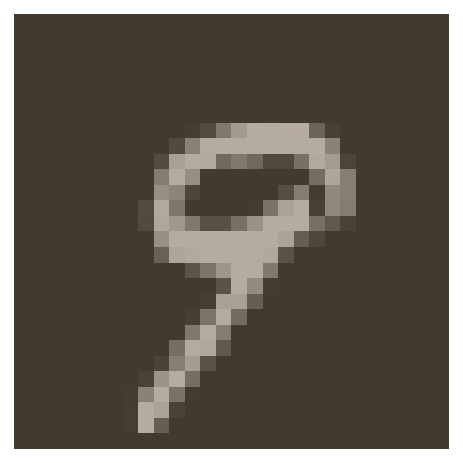

In [144]:
# Run this to test the data loader
images, labels = next(iter(trainloader))
helper.imshow(images[0], normalize=True)

In [150]:
#building the model
input_layer = 784
hidden_layers = [256, 128]
output_layer = 10

model = nn.Sequential(nn.Linear(input_layer, hidden_layers[0]),
                    nn.ReLU(),
                    nn.Dropout(p=0.2),
                    nn.Linear(hidden_layers[0], hidden_layers[1]),
                    nn.ReLU(),
                    nn.Dropout(p=0.2),
                    nn.Linear(hidden_layers[1], output_layer),
                    nn.Softmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=10, bias=True)
  (7): Softmax(dim=1)
)


In [146]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03)

epochs = 30
training_losses = []
testing_losses = []

for e in range(epochs):
    #training the model
    total_training_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()
        logps = model(images) #basically runs all the images through the model
        # the logps is the probability of each class
        # [0.0866, 0.0972, 0.0922, 0.0732, 0.1116, 0.1409, 0.1010, 0.1072, 0.0893, 0.1007]
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        total_training_loss += loss.item() #contains the loss of entire mini-batch, but divided by the batch size
        
    else:
        #testing the model
        total_testing_loss = 0
        test_correct = 0
        with torch.no_grad():
            model.eval() #dropout turns off
            for images, labels in testloader: #since there is no training, there is no need for gradients
                images = images.view(images.shape[0], -1)
                logps = model(images)
                loss = criterion(logps, labels)
                total_testing_loss  += loss.item()

                ps = torch.exp(model(images)) #get the class probabilities - you can subsitute logps into the brackets as well

                top_p, top_class = ps.topk(1, dim=1) #the probability values and the indices of these values - the ps.topk gives us the highest probaility, whivh is what class it predicts

                equals = top_class == labels.view(*top_class.shape) #you make the labels the same shape and then you compare; if you get [0]s = didn't match, [1]s = did match

                test_correct += torch.mean(equals.type(torch.FloatTensor)) #you can find the mean of 0s and 1s in the batch to see how accurate it was after 1 epoch

        model.train() #dropout back on

        training_losses.append(total_training_loss / len(trainloader))
        testing_losses.append(total_testing_loss / len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
        "Train Loss: {:.3f}.. ".format(training_losses[-1]),
        "Test Loss: {:.3f}.. ".format(testing_losses[-1]),
        "Test Accuracy: {:.3f}".format(test_correct / len(testloader)))



Epoch: 1/30..  Train Loss: -0.267..  Test Loss: -0.525..  Test Accuracy: 0.568
Epoch: 2/30..  Train Loss: -0.606..  Test Loss: -0.756..  Test Accuracy: 0.805
Epoch: 3/30..  Train Loss: -0.768..  Test Loss: -0.818..  Test Accuracy: 0.833
Epoch: 4/30..  Train Loss: -0.809..  Test Loss: -0.870..  Test Accuracy: 0.894
Epoch: 5/30..  Train Loss: -0.860..  Test Loss: -0.895..  Test Accuracy: 0.909
Epoch: 6/30..  Train Loss: -0.882..  Test Loss: -0.907..  Test Accuracy: 0.918
Epoch: 7/30..  Train Loss: -0.891..  Test Loss: -0.913..  Test Accuracy: 0.922
Epoch: 8/30..  Train Loss: -0.900..  Test Loss: -0.919..  Test Accuracy: 0.928
Epoch: 9/30..  Train Loss: -0.906..  Test Loss: -0.923..  Test Accuracy: 0.930
Epoch: 10/30..  Train Loss: -0.911..  Test Loss: -0.926..  Test Accuracy: 0.932
Epoch: 11/30..  Train Loss: -0.917..  Test Loss: -0.930..  Test Accuracy: 0.937
Epoch: 12/30..  Train Loss: -0.921..  Test Loss: -0.934..  Test Accuracy: 0.940
Epoch: 13/30..  Train Loss: -0.925..  Test Loss: 

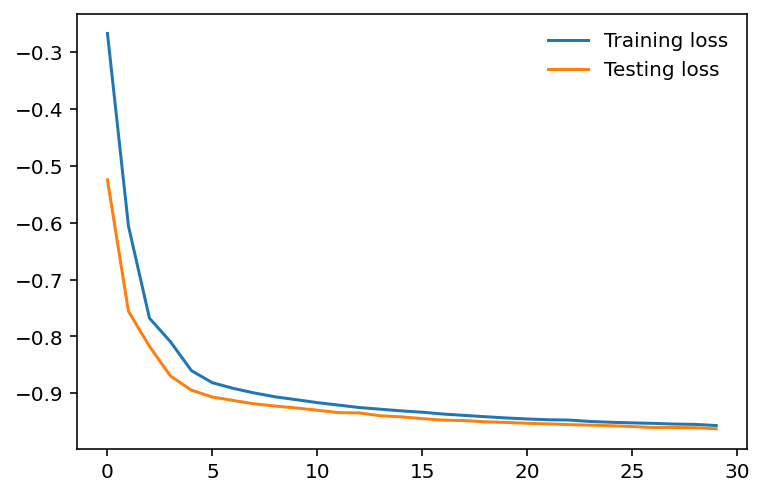

In [147]:
plt.plot(training_losses, label="Training loss")
plt.plot(testing_losses, label="Testing loss")
plt.legend(frameon=False)

tensor(4)


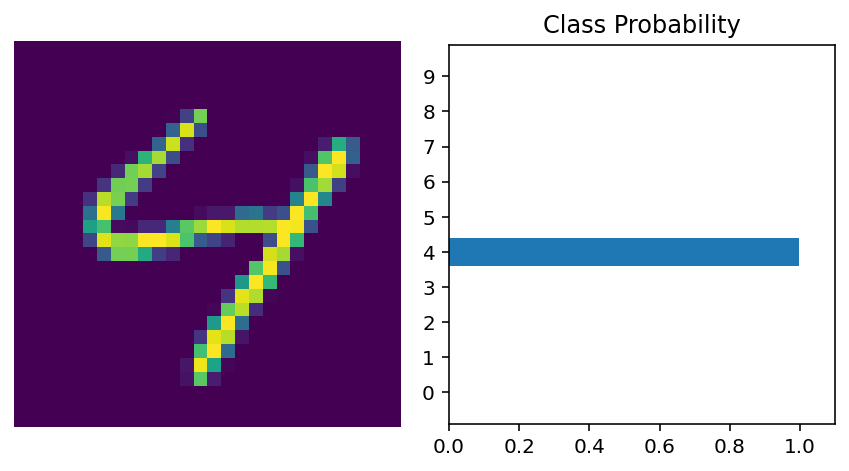

In [148]:
images, labels = next(iter(testloader))
images.resize_(images.shape[0], 1, 784)
ps = model(images[0,:])

helper.view_classify(images[0].view(1,28,28), ps)
print(labels[0])